In [1]:
%matplotlib widget

from pathlib import Path
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("matplotlib_style.txt")

import numpy as np
import pandas as pd

np.random.seed(42)

import sklearn
from openTSNE import TSNE
from rnanorm import CTF  # pip install rnanorm
from umap import UMAP

/home/izumigodai/anaconda3/envs/datasci/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/izumigodai/anaconda3/envs/datasci/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/izumigodai/anaconda3/envs/datasci/lib/python3.11/site-

In [2]:
import plots, utils

In [3]:
import jupyter_black
jupyter_black.load(line_length=79)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

In [4]:
data_path = Path("../data")

## Import

### Meta data

In [5]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

**Exon counts**

In [6]:
data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
assert all(cells == data_exons.columns)

genes = data_exons.index
exonCounts = data_exons.transpose()

print("Count matrix shape (exon):  ", exonCounts.shape)
exonCounts.head()

Count matrix shape (exon):   (1329, 42466)


,0610005C13Rik,0610006L08Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610010F05Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,n-R5s82,n-R5s84,n-R5s85,n-R5s86,n-R5s88,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
20171204_sample_2,0,0,0,0,0,1478,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20171204_sample_4,0,0,68,0,0,8,0,0,0,29,...,0,0,0,0,0,0,0,0,0,0
20171204_sample_5,0,0,1291,0,0,1562,0,2381,0,0,...,0,0,0,0,0,0,0,0,0,0
20171204_sample_6,0,0,0,0,0,581,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20171207_sample_1,0,0,0,30,0,62,0,79,0,277,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data_gene_len = pd.read_csv(data_path / "gene_lengths.txt", index_col=0)
assert all(data_gene_len.index == genes)

exonLengths = data_gene_len["exon_bp"]
exonLengths.head()

GeneID
0610005C13Rik    3583
0610006L08Rik    2128
0610009B22Rik     998
0610009E02Rik    1803
0610009L18Rik     619
Name: exon_bp, dtype: int64

### Cluster colors

In [8]:
cluster_colors = np.load(data_path / "cluster_colors.npy")

In [9]:
cluster_colors.shape

(1329,)

In [10]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)

In [11]:
rna_type.shape

(1329,)

In [12]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [13]:
len(dict_rna_type_colors)

88

### Electrophysiological features

In [14]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [15]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [16]:
np.sum(np.isnan(ephysData_filtered))

0

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

## 1) Inspecting Data

In [17]:
# check for nan
assert not exonCounts.isna().any(axis=None)

In [18]:
# Kick out all genes with all counts = 0
genes = genes[exonCounts.sum(axis=0) > 0]
exonLengths = exonLengths[exonCounts.sum(axis=0) > 0]
exonCounts = exonCounts.loc[:, exonCounts.sum(axis=0) > 0]

# check if they keep same size
assert genes.size == exonCounts.shape[1]

In [19]:
# Compute the average expression for each gene
avg_counts = exonCounts.mean(axis=0)

# Compute the fraction of zeros for each gene
zero_fraction = np.sum(exonCounts == 0, axis=0) / exonCounts.shape[0]

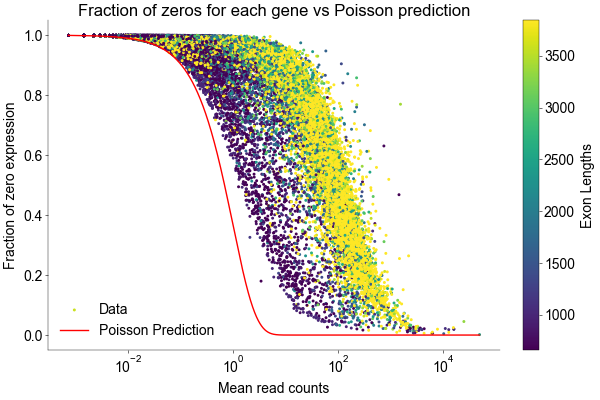

In [20]:
plots.plot_zero_fraction(
    avg_counts,
    zero_fraction,
    cmap="viridis",
    c=exonLengths,
    vmin=exonLengths.quantile(0.25),
    vmax=exonLengths.quantile(0.75),
)

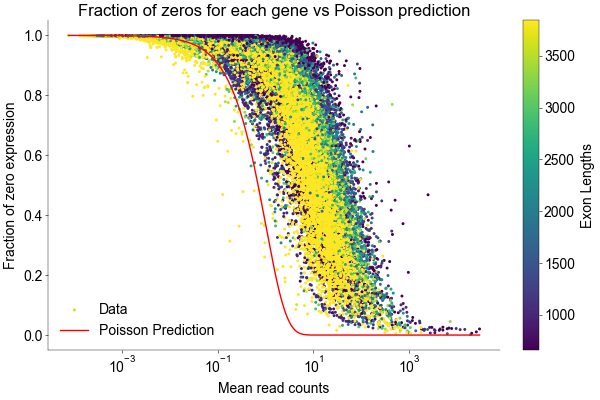

In [21]:
avg_counts_corrected = avg_counts / (exonLengths * 1e-3)

plots.plot_zero_fraction(
    avg_counts_corrected,
    zero_fraction,
    cmap="viridis",
    c=exonLengths,
    vmin=exonLengths.quantile(0.25),
    vmax=exonLengths.quantile(0.75),
)

Chen, W., Li, Y., Easton, J. et al. UMI-count modeling and differential expression analysis for single-cell RNA sequencing. Genome Biol 19, 70 (2018). https://doi.org/10.1186/s13059-018-1438-9

Jiang, R., Sun, T., Song, D. et al. Statistics or biology: the zero-inflation controversy about scRNA-seq data. Genome Biol 23, 31 (2022). https://doi.org/10.1186/s13059-022-02601-


As we were expecting, the read counts seem to deviate significantly from the Poisson model. First observation is that the fraction of zeroes observed is consistently higher than a poisson model would predict. Another one is a visually noticeable variability of the mean read counts for a same fraction of zeros, resulting in a wide curve (very different from what was observed in the dataset of CodingLab 7). One of the main factors underlying this deviances is probably the so-called amplification bias. Since the amount of transcripts collected from single cells is very small, cDNA amplification is necessary for the construction of the library. Nevertheless, this amplification is also a stochastic process, resulting in distortions (e.g., the same amount of a specific transcript was captured for two different cells. But in one of them, the cDNA amplification lead to a higher amount of read counts) (Chen et al. 2018). The UMI techniques try to mitigate this bias, by tagging the transcripts befor amplification.

Another point raised by Chen et al. (2018) is the higher number of dropout events in single cell sequencing (missing values, due to biological and technical stochasticities). The authors argue that accounting for these kind of event is relevant for read counts, but not much for UMI. Apparently, there is a big discussion in the scRNA-seq field if models should include zero inflations (to correct for the dropout events) or not (Jiang et al. 2022). 

### Some statistics

In [22]:
depth = np.sum(exonCounts, axis=1)
genes_detected = np.sum(exonCounts != 0, axis=1)

# Basic statistics (same reported in GitHub https://github.com/berenslab/mini-atlas/blob/master/code/ttype-assignment.ipynb)
print(
    "Depth: median {:.0f}, mean+-STD log10: {:.1f}+-{:.1f}".format(
        np.median(depth), np.mean(np.log10(depth)), np.std(np.log10(depth))
    )
)
print(
    "Genes detected per cell: median {:.0f}, mean+-STD: {:.0f}+-{:.0f}".format(
        np.median(genes_detected),
        np.mean(genes_detected),
        np.std(genes_detected),
    )
)

Depth: median 1281492, mean+-STD log10: 6.0+-0.6
Genes detected per cell: median 6897, mean+-STD: 6766+-2742


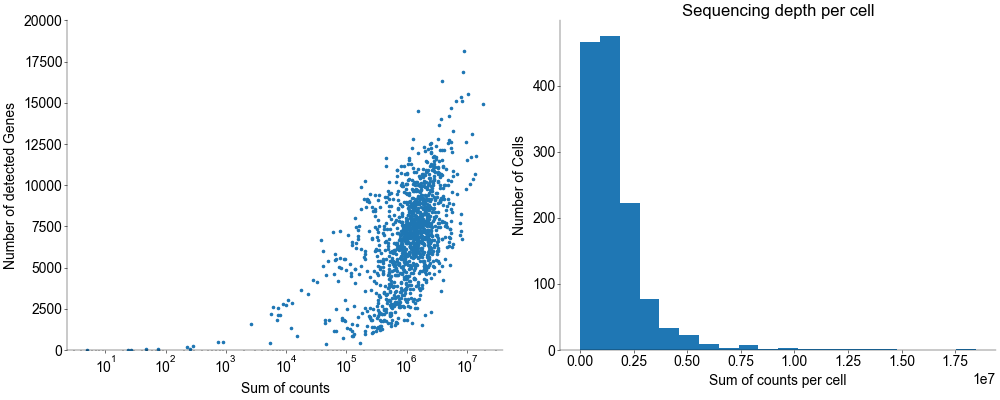

In [23]:
plots.plot_depth_per_cell(depth, genes_detected)

#### Mean-Variance analysis

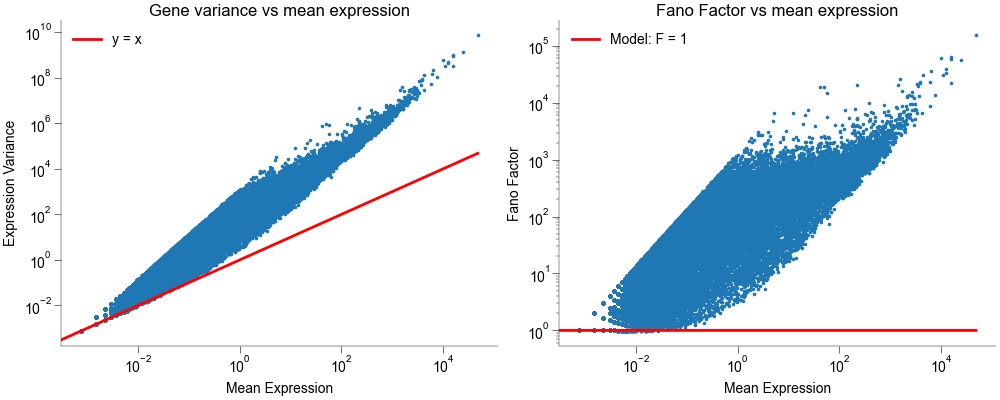

In [24]:
plots.plot_fano_factor(exonCounts)

Chosen offset: 7.64


/home/izumigodai/dev/git/neural-data-science-project/notebooks/utils.py:112: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


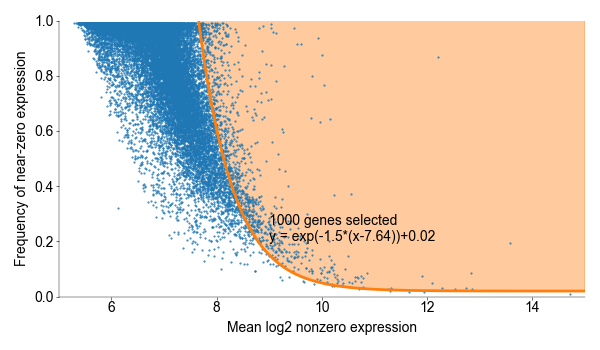

1000


In [25]:
genesForRRR = utils.geneSelection(
    exonCounts, n=1000, threshold=32, decay=1.5, yoffset=0.02
)
print(np.sum(genesForRRR))

## Normalization and Transformation

### CTF normalization

Write about the different methods. In blog they suggest one for single cell sequencing, but didnt find python implementation. Took CTF from another paper, which claimed it is more robust (https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02568-9). Method is implemented in library (https://pypi.org/project/rnanorm/)



In [26]:
print(pd.DataFrame(exonCounts).shape)
CTF_exon_counts = (
    CTF()
    .set_output(transform="pandas")
    .fit_transform(pd.DataFrame(exonCounts))
)
CTF_exon_counts = CTF_exon_counts.values

(1329, 42197)


/home/izumigodai/anaconda3/envs/datasci/lib/python3.11/site-packages/rnanorm/methods/between_sample.py:93: RuntimeWarning: divide by zero encountered in divide
  return factors / self.geometric_mean_
/home/izumigodai/anaconda3/envs/datasci/lib/python3.11/site-packages/rnanorm/methods/between_sample.py:93: RuntimeWarning: invalid value encountered in divide
  return factors / self.geometric_mean_


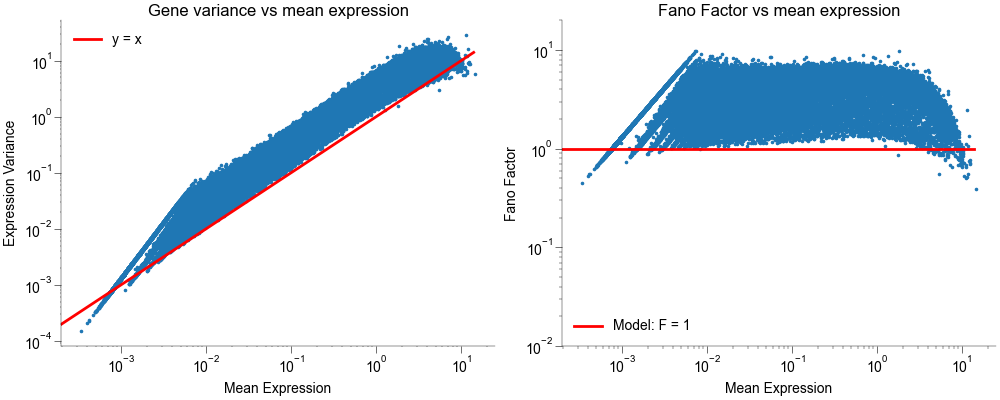

In [27]:
log_CTF_exon_counts = np.log2(CTF_exon_counts + 1)

plots.plot_fano_factor(log_CTF_exon_counts, ylim=(0.01, 20))

In GitHub of original paper, it seems that the normalization applied was: counts / (exonLenght / 1000). So we will also use this one for comparison.



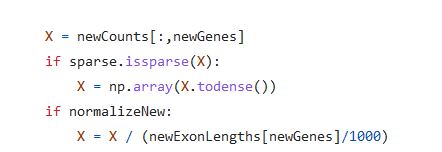

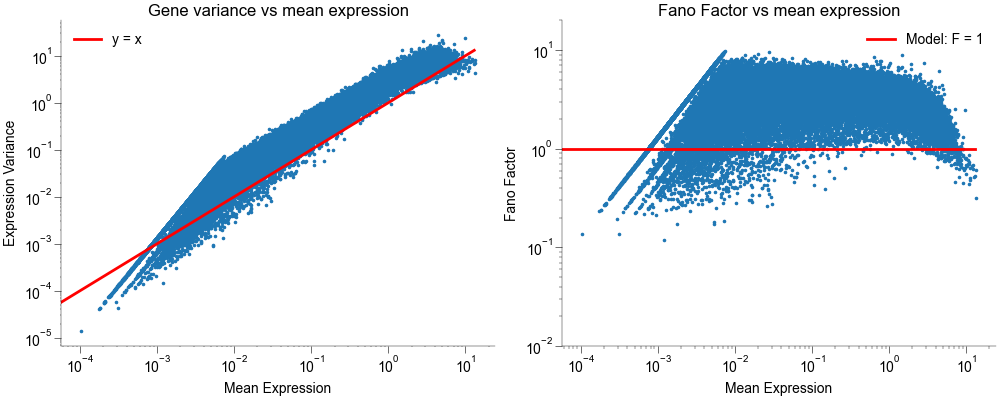

In [28]:
norm_counts = exonCounts / (exonLengths / 1000)
log_norm_counts = np.log2(norm_counts + 1)

plots.plot_fano_factor(log_norm_counts, ylim=(0.01, 20))

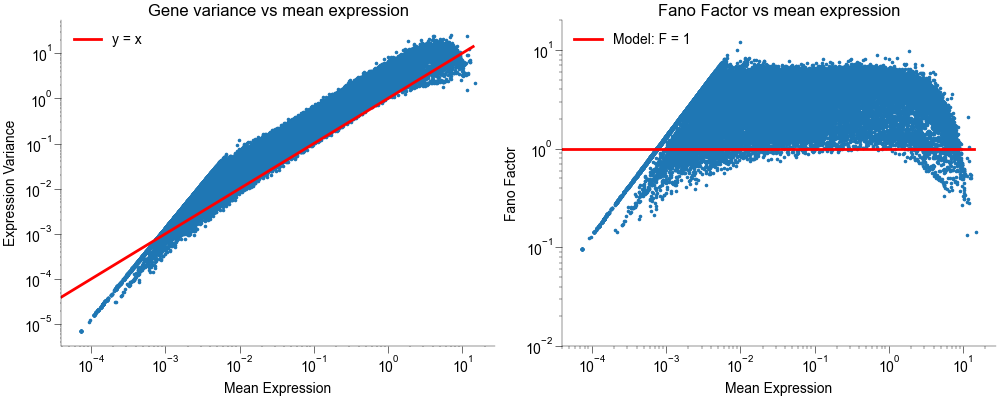

In [29]:
depth_median = np.median(depth)
norm_factor = np.array(depth_median * (1 / depth))

norm_counts = norm_factor[:, np.newaxis] * exonCounts
# norm_counts = exonCounts / (exonLengths / 1000)
log_norm_counts = np.log2(norm_counts + 1)

plots.plot_fano_factor(log_norm_counts, ylim=(0.01, 20))

### PCA vizualization for different transformations and normalization

In [30]:
# Perform PCA three times for each normalization: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform

from sklearn.decomposition import PCA


Fano = np.var(log_CTF_exon_counts, axis=0) / np.mean(
    log_CTF_exon_counts, axis=0
)
Selected_genes = Fano > 5
print(np.sum(Selected_genes))
# CTF
sqrt_CTF = np.sqrt(CTF_exon_counts)

# perform PCA
pca = PCA(n_components=50)
pca_CTF = pca.fit_transform(CTF_exon_counts[:, genesForRRR])
pca_log_CTF = pca.fit_transform(log_CTF_exon_counts[:, genesForRRR])
pca_sqrt_CTF = pca.fit_transform(sqrt_CTF[:, genesForRRR])

# Gene lenght norm
Fano = np.var(log_norm_counts, axis=0) / np.mean(log_norm_counts, axis=0)
Selected_genes = Fano > 6
print(np.sum(Selected_genes))

sqrt_norm = np.sqrt(norm_counts)

# perform PCA
pca = PCA(n_components=50)
pca_norm_counts = pca.fit_transform(norm_counts.loc[:, Selected_genes])
pca_log2_norm_counts = pca.fit_transform(
    log_norm_counts.loc[:, Selected_genes]
)
pca_sqrt_norm_counts = pca.fit_transform(sqrt_norm.loc[:, Selected_genes])

9324
1043


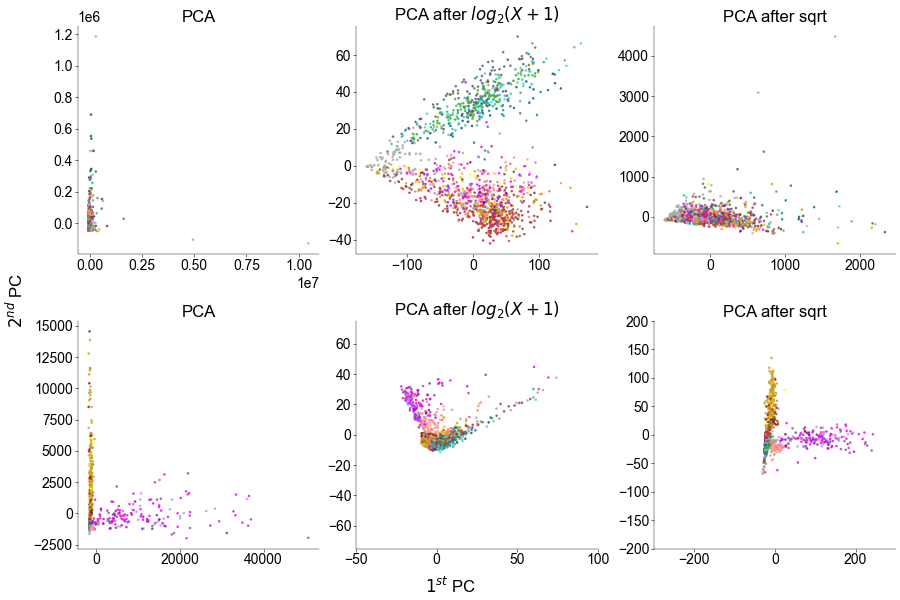

In [31]:
plots.plot_CTF(
    pca_CTF,
    pca_log_CTF,
    pca_sqrt_CTF,
    pca_norm_counts,
    pca_log2_norm_counts,
    pca_sqrt_norm_counts,
    cluster_colors,
)

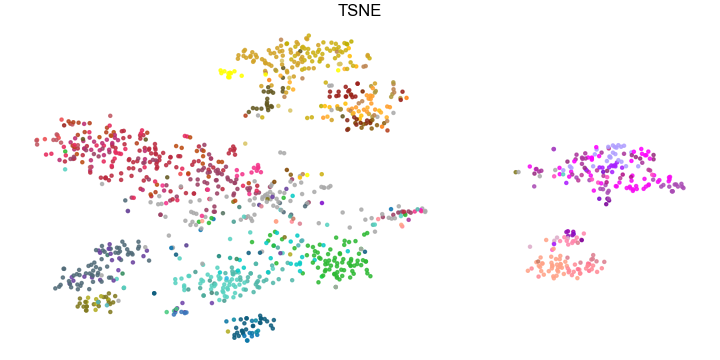

In [32]:
tsne = TSNE(perplexity=30)
tsne_counts = tsne.fit(pca_sqrt_norm_counts)

plots.plot_TSNE(tsne_counts, cluster_colors)